In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from scipy import stats

In [3]:
train = pd.read_csv('train_air.csv')
test = pd.read_csv('test_air.csv')


In [4]:
train['satisfaction']

0         neutral or dissatisfied
1         neutral or dissatisfied
2                       satisfied
3         neutral or dissatisfied
4                       satisfied
                   ...           
103899    neutral or dissatisfied
103900                  satisfied
103901    neutral or dissatisfied
103902    neutral or dissatisfied
103903    neutral or dissatisfied
Name: satisfaction, Length: 103904, dtype: object

In [5]:
df =  pd.concat([train, test])


In [6]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


# Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      12988

In [8]:
df['Departure Delay in Minutes'].max()

1592

In [9]:
df['Departure Delay in Minutes'].describe()

count    129880.000000
mean         14.713713
std          38.071126
min           0.000000
25%           0.000000
50%           0.000000
75%          12.000000
max        1592.000000
Name: Departure Delay in Minutes, dtype: float64

# Searching For Unique Values

In [10]:
print('########### Numerical ##########')
for col in df.columns:
    if df[col].dtype!='object':
        print(col,':',df[col].nunique())
print(" ")
print('############# Category #############')        
for col in df.columns:
    if df[col].dtype=='object':
        print(col,':',df[col].nunique())

########### Numerical ##########
Unnamed: 0 : 103904
id : 129880
Age : 75
Flight Distance : 3821
Inflight wifi service : 6
Departure/Arrival time convenient : 6
Ease of Online booking : 6
Gate location : 6
Food and drink : 6
Online boarding : 6
Seat comfort : 6
Inflight entertainment : 6
On-board service : 6
Leg room service : 6
Baggage handling : 5
Checkin service : 6
Inflight service : 6
Cleanliness : 6
Departure Delay in Minutes : 466
Arrival Delay in Minutes : 472
 
############# Category #############
Gender : 2
Customer Type : 2
Type of Travel : 2
Class : 3
satisfaction : 2


# Missing Values

In [11]:
df.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction    

# Convertions For Our Features

In [12]:
df['Arrival Delay in Minutes']=df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())


In [13]:
df['Gender']=df['Gender'].map({'Male':1,'Female':0})
df['satisfaction']=df['satisfaction'].map({'satisfied':1,'neutral or dissatisfied':0})
df['Customer Type']=df['Customer Type'].map({'Loyal Customer':1,'disloyal Customer':0})
df['Type of Travel']=df['Type of Travel'].map({'Personal Travel':1,'Business travel':0})

In [14]:
df_class = pd.get_dummies(df['Class'])

In [15]:
concatenated_df = pd.concat([df, df_class], axis=1)
df_new = concatenated_df.drop(['id','Unnamed: 0','Class'] , axis=1)


In [16]:
df_new.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Flight Distance',
       'Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'Business', 'Eco', 'Eco Plus'],
      dtype='object')

# Correlations

<AxesSubplot:>

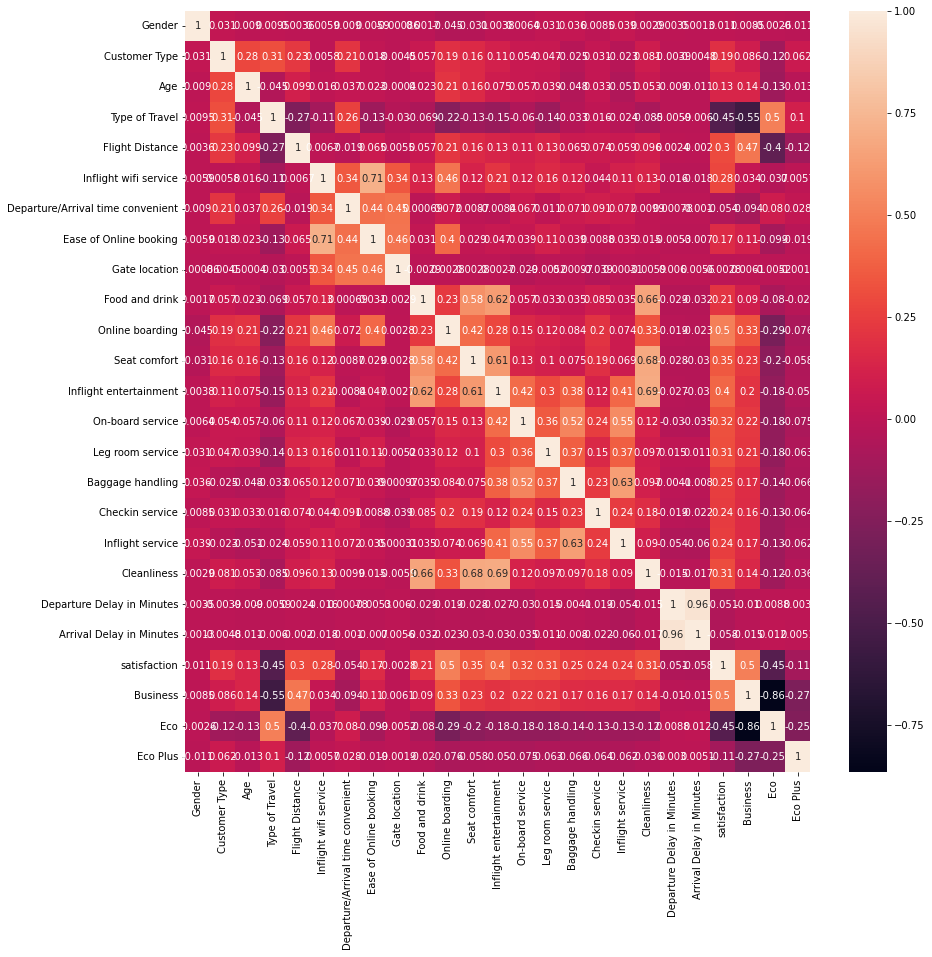

In [17]:
plt.figure(figsize=(14,14))
sns.heatmap(df_new.corr(),annot=True)

# Select Features With Correlations Smaller Than 0.8

In [18]:
corr_matrix = df_new.drop('satisfaction',axis=1).corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.8)]
df1=df_new.drop(to_drop, axis=1)

In [19]:
df1

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Business,Eco Plus
0,1,1,13,1,460,3,4,3,1,5,...,4,3,4,4,5,5,25,0,0,1
1,1,0,25,0,235,3,2,3,3,1,...,1,5,3,1,4,1,1,0,1,0
2,0,1,26,0,1142,2,2,2,2,5,...,4,3,4,4,4,5,0,1,1,0
3,0,1,25,0,562,2,5,5,5,2,...,2,5,3,1,4,2,11,0,1,0
4,1,1,61,0,214,3,3,3,3,4,...,3,4,4,3,3,3,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,1,0,34,0,526,3,3,3,1,4,...,3,2,4,4,5,4,0,0,1,0
25972,1,1,23,0,646,4,4,4,4,4,...,4,5,5,5,5,4,0,1,1,0
25973,0,1,17,1,828,2,5,1,5,2,...,4,3,4,5,4,2,0,0,0,0
25974,1,1,14,0,1127,3,3,3,3,4,...,3,2,5,4,5,4,0,1,1,0


# Checking Our Target If Is Balanced Or Imbalanced

<AxesSubplot:xlabel='satisfaction', ylabel='count'>

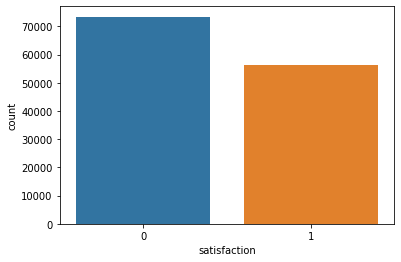

In [20]:
sns.countplot(x=df1['satisfaction'])

# Distribution of Satisfaction

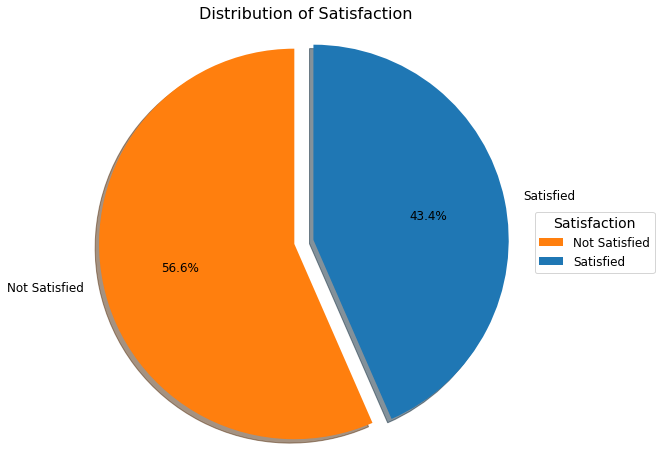

In [21]:
import matplotlib.pyplot as plt

satisfaction_counts = df1['satisfaction'].value_counts()

# Create a dictionary for label mapping
label_mapping = {0: 'Not Satisfied', 1: 'Satisfied'}
satisfaction_counts.index = satisfaction_counts.index.map(label_mapping)

# Create the pie chart
plt.figure(figsize=(8, 8))
colors = ['#FF7F0E', '#1F77B4']
explode = (0.1, 0)  # Explode the first slice for emphasis
plt.pie(satisfaction_counts, labels=satisfaction_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True, textprops={'fontsize': 12})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Satisfaction', fontsize=16)

# Add legend with increased font size
legend_labels = ['Not Satisfied', 'Satisfied']
plt.legend(title='Satisfaction', labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12}, title_fontsize='14')

# Increase font size of other elements
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# conclusion
From the two Graphs, we can see that our target is balanced


# Visualization About Our Target and Features

<Figure size 1944x1512 with 0 Axes>

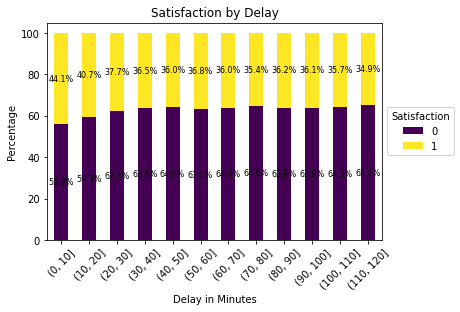

In [22]:
import matplotlib.pyplot as plt

# Define the ranges for delay in minutes
ranges = [0, 10, 20, 30, 40, 50,60,70,80,90,100,110,120]

# Group the data based on the ranges and calculate the count of satisfaction = 1 and 0
df_grouped = df.groupby([pd.cut(df['Departure Delay in Minutes'], ranges), 'satisfaction']).size().unstack()

# Calculate percentages
df_grouped_percent = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100

# Create a stacked bar plot
plt.figure(figsize=(27, 21))
ax = df_grouped_percent.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Delay in Minutes')
plt.ylabel('Percentage')
plt.title('Satisfaction by Delay')
plt.xticks(rotation=45)

# Add count numbers as percentages within each bar
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', fontsize=8)

# Move the legend outside the plot
ax.legend(title = 'Satisfaction',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

<Figure size 1224x1224 with 0 Axes>

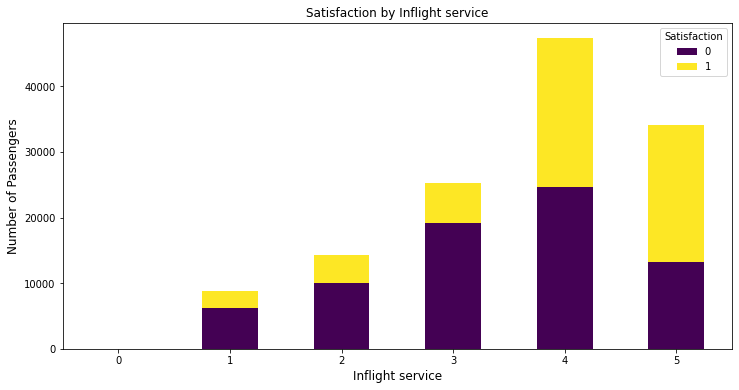

In [23]:
# 1.Satisfaction
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(17,17))
satisfaction_counts = pd.crosstab(df['Inflight service'], df['satisfaction'])
satisfaction_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.legend(title='Satisfaction', loc='best')
plt.title('Satisfaction by Inflight service')
plt.xlabel('Inflight service', fontsize=12)  
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(rotation=0)
plt.show()

<Figure size 864x432 with 0 Axes>

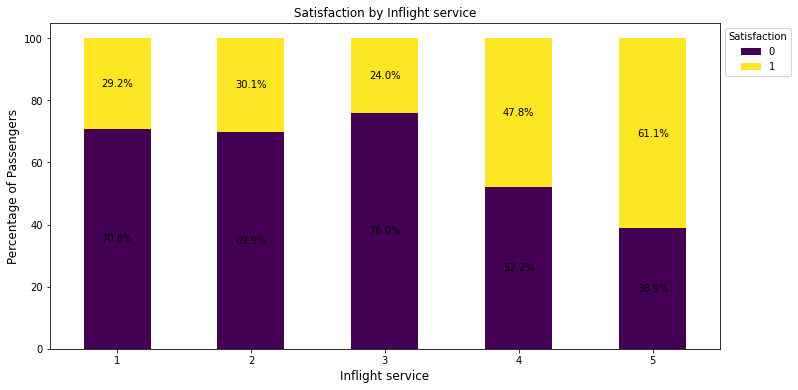

In [24]:
# With Percentage
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
satisfaction_counts = pd.crosstab(df['Inflight service'], df['satisfaction'])
satisfaction_percentages = satisfaction_counts.div(satisfaction_counts.sum(1), axis=0) * 100

# Filter out the zero value category
satisfaction_percentages = satisfaction_percentages.loc[satisfaction_percentages.index != 0]

satisfaction_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

plt.legend(title='Satisfaction',bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Satisfaction by Inflight service')
plt.xlabel('Inflight service', fontsize=12)
plt.ylabel('Percentage of Passengers', fontsize=12)
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.show()

<Figure size 1224x1224 with 0 Axes>

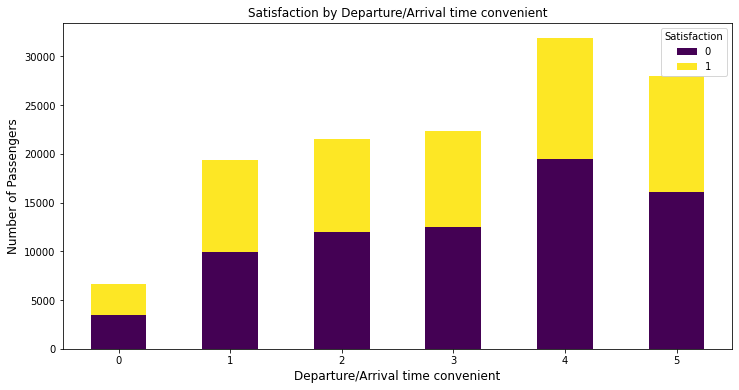

In [25]:
# 1.Satisfaction
df_c = df.copy()
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(17,17))
satisfaction_counts = pd.crosstab(df['Departure/Arrival time convenient'], df['satisfaction'])
satisfaction_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.legend(title='Satisfaction', loc='best')
plt.title('Satisfaction by Departure/Arrival time convenient')
plt.xlabel('Departure/Arrival time convenient', fontsize=12)  
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(rotation=0)
plt.show()

<Figure size 864x432 with 0 Axes>

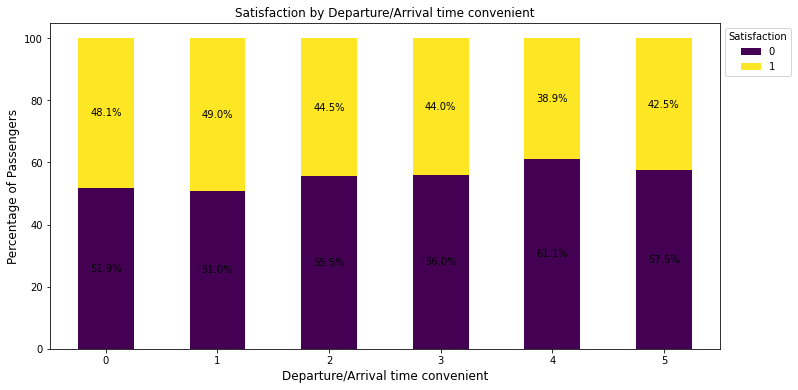

In [26]:
# With Percentage
import matplotlib.pyplot as plt
import pandas as pd

df_c = df.copy()
plt.figure(figsize=(12, 6))
satisfaction_counts = pd.crosstab(df_c['Departure/Arrival time convenient'], df_c['satisfaction'])
satisfaction_percentages = satisfaction_counts.div(satisfaction_counts.sum(1), axis=0) * 100

satisfaction_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

plt.legend(title='Satisfaction', bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Satisfaction by Departure/Arrival time convenient')
plt.xlabel('Departure/Arrival time convenient', fontsize=12)
plt.ylabel('Percentage of Passengers', fontsize=12)
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.show()

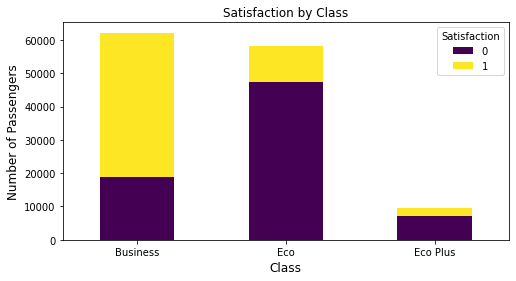

<Figure size 432x288 with 0 Axes>

In [27]:
# 1.Satisfaction
import matplotlib.pyplot as plt
import pandas as pd

satisfaction_counts = pd.crosstab(df['Class'], df['satisfaction'])
satisfaction_counts.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='viridis')
plt.legend(title='Satisfaction', loc='best')
plt.title('Satisfaction by Class')
plt.xlabel('Class', fontsize=12)  
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(rotation=0)
plt.show()
plt.savefig('class-satisfa.png', dpi=300)  # Export the plot as a PNG file
plt.show()

<Figure size 576x288 with 0 Axes>

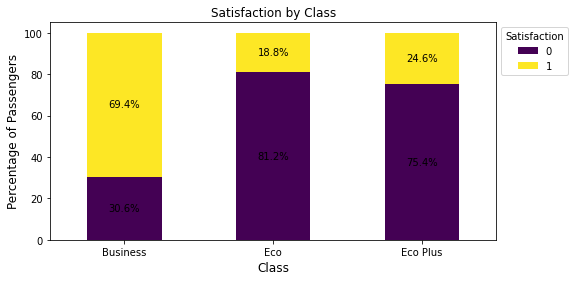

In [28]:
# With Percentage
import matplotlib.pyplot as plt
import pandas as pd

satisfaction_counts = pd.crosstab(df['Class'], df['satisfaction'])
satisfaction_percentages = satisfaction_counts.div(satisfaction_counts.sum(1), axis=0) * 100

plt.figure(figsize=(8, 4))
satisfaction_percentages.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='viridis')

plt.legend(title='Satisfaction', bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Satisfaction by Class')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Percentage of Passengers', fontsize=12)
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.savefig('class-satisfa.png', dpi=300)  # Export the plot as a PNG file
plt.show()

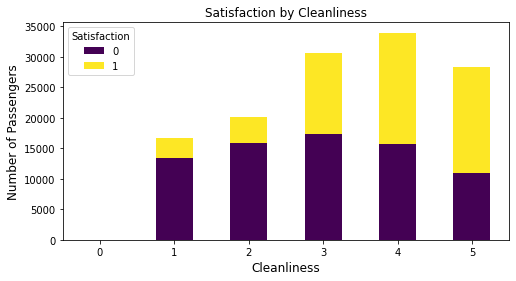

<Figure size 432x288 with 0 Axes>

In [29]:
# 1.Cleanliness
import matplotlib.pyplot as plt
import pandas as pd

satisfaction_counts = pd.crosstab(df['Cleanliness'], df['satisfaction'])
satisfaction_counts.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='viridis')
plt.legend(title='Satisfaction', loc='best')
plt.title('Satisfaction by Cleanliness')
plt.xlabel('Cleanliness', fontsize=12)  
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(rotation=0)
plt.show()
plt.savefig('clean-satisfa.png', dpi=300)  # Export the plot as a PNG file
plt.show()

<Figure size 576x288 with 0 Axes>

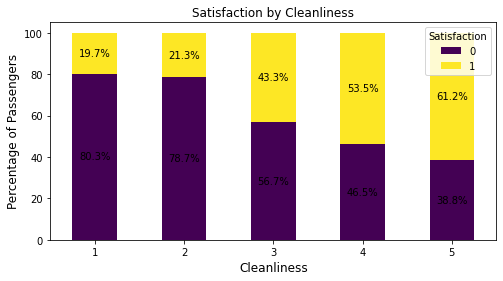

In [30]:
# With Percentage
import matplotlib.pyplot as plt
import pandas as pd

satisfaction_counts = pd.crosstab(df['Cleanliness'], df['satisfaction'])
satisfaction_percentages = satisfaction_counts.div(satisfaction_counts.sum(1), axis=0) * 100

# Filter out the zero value category
satisfaction_percentages = satisfaction_percentages.loc[satisfaction_percentages.index != 0]

plt.figure(figsize=(8, 4))
satisfaction_percentages.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='viridis')

plt.legend(title='Satisfaction', loc='best')
plt.title('Satisfaction by Cleanliness')
plt.xlabel('Cleanliness', fontsize=12)
plt.ylabel('Percentage of Passengers', fontsize=12)
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.savefig('clean-satisfa.png', dpi=300)  # Export the plot as a PNG file
plt.show()

# Machine Learning - Predictions

In [31]:
X = df1.drop('satisfaction',axis=1)
y = df1['satisfaction']

X_train ,X_test ,y_train, y_test = train_test_split(X,y,random_state=91,test_size=0.3)
# Normalize Features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=20)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, random_state=20)

In [33]:
rf_test_preds = rf.predict(X_test)


In [34]:
# Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_test_preds))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_test_preds))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     22019
           1       0.92      0.89      0.90     16945

    accuracy                           0.92     38964
   macro avg       0.92      0.91      0.92     38964
weighted avg       0.92      0.92      0.92     38964

Random Forest Confusion Matrix:
[[20677  1342]
 [ 1866 15079]]


# Logistic Regression

In [35]:
logreg = LogisticRegression(C=1.0, solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [36]:
logreg_test_preds = logreg.predict(X_test)


In [37]:
# Logistic
print("Logistic:")
print(classification_report(y_test, logreg_test_preds))
print("Logistic:")
print(confusion_matrix(y_test, logreg_test_preds))

Logistic:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     22019
           1       0.87      0.84      0.85     16945

    accuracy                           0.87     38964
   macro avg       0.87      0.87      0.87     38964
weighted avg       0.87      0.87      0.87     38964

Logistic:
[[19923  2096]
 [ 2775 14170]]


# GaussianNB

In [38]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions
nb_test_preds = nb_classifier.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_test_preds))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, nb_test_preds))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     22019
           1       0.85      0.81      0.83     16945

    accuracy                           0.85     38964
   macro avg       0.85      0.85      0.85     38964
weighted avg       0.85      0.85      0.85     38964

Naive Bayes Confusion Matrix:
[[19559  2460]
 [ 3233 13712]]


# Gradient Boosting

In [39]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Make predictions
gb_test_preds = gb_classifier.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_test_preds))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, gb_test_preds))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     22019
           1       0.94      0.92      0.93     16945

    accuracy                           0.94     38964
   macro avg       0.94      0.94      0.94     38964
weighted avg       0.94      0.94      0.94     38964

Gradient Boosting Confusion Matrix:
[[21101   918]
 [ 1360 15585]]


# Desicion Trees

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Make predictions
dt_test_preds = dt_classifier.predict(X_test)

# Evaluate the classifier
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_test_preds))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_test_preds))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     22019
           1       0.94      0.94      0.94     16945

    accuracy                           0.95     38964
   macro avg       0.95      0.95      0.95     38964
weighted avg       0.95      0.95      0.95     38964

Decision Tree Confusion Matrix:
[[20935  1084]
 [ 1014 15931]]


# AdaBoostClassifier

In [41]:
from sklearn.ensemble import AdaBoostClassifier
# Create an AdaBoost classifier
adaboost_classifier = AdaBoostClassifier()
# Train the classifier
adaboost_classifier.fit(X_train, y_train)
# Make predictions
adaboost_test_preds = adaboost_classifier.predict(X_test)
# Evaluate the classifier
print("AdaBoost Classification Report:")
print(classification_report(y_test, adaboost_test_preds))
print("AdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, adaboost_test_preds))

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     22019
           1       0.92      0.91      0.92     16945

    accuracy                           0.93     38964
   macro avg       0.93      0.92      0.93     38964
weighted avg       0.93      0.93      0.93     38964

AdaBoost Confusion Matrix:
[[20690  1329]
 [ 1531 15414]]


# LightGBM

In [42]:
import lightgbm as lgb
# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()
# Train the classifier
lgb_classifier.fit(X_train, y_train)
# Make predictions
lgb_test_preds = lgb_classifier.predict(X_test)
# Evaluate the classifier
print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_test_preds))
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, lgb_test_preds))

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     22019
           1       0.98      0.94      0.96     16945

    accuracy                           0.96     38964
   macro avg       0.97      0.96      0.96     38964
weighted avg       0.97      0.96      0.96     38964

LightGBM Confusion Matrix:
[[21637   382]
 [  993 15952]]


# XGBoost

In [43]:
import xgboost as xgb
# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
# Train the classifier
xgb_classifier.fit(X_train, y_train)
# Make predictions
xgb_test_preds = xgb_classifier.predict(X_test)
# Evaluate the classifier
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_test_preds))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_test_preds))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     22019
           1       0.97      0.94      0.96     16945

    accuracy                           0.96     38964
   macro avg       0.97      0.96      0.96     38964
weighted avg       0.96      0.96      0.96     38964

XGBoost Confusion Matrix:
[[21591   428]
 [  948 15997]]


# Conclusion
Xgboost and lightGBM classifier are the best algorithms for predictive models

# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

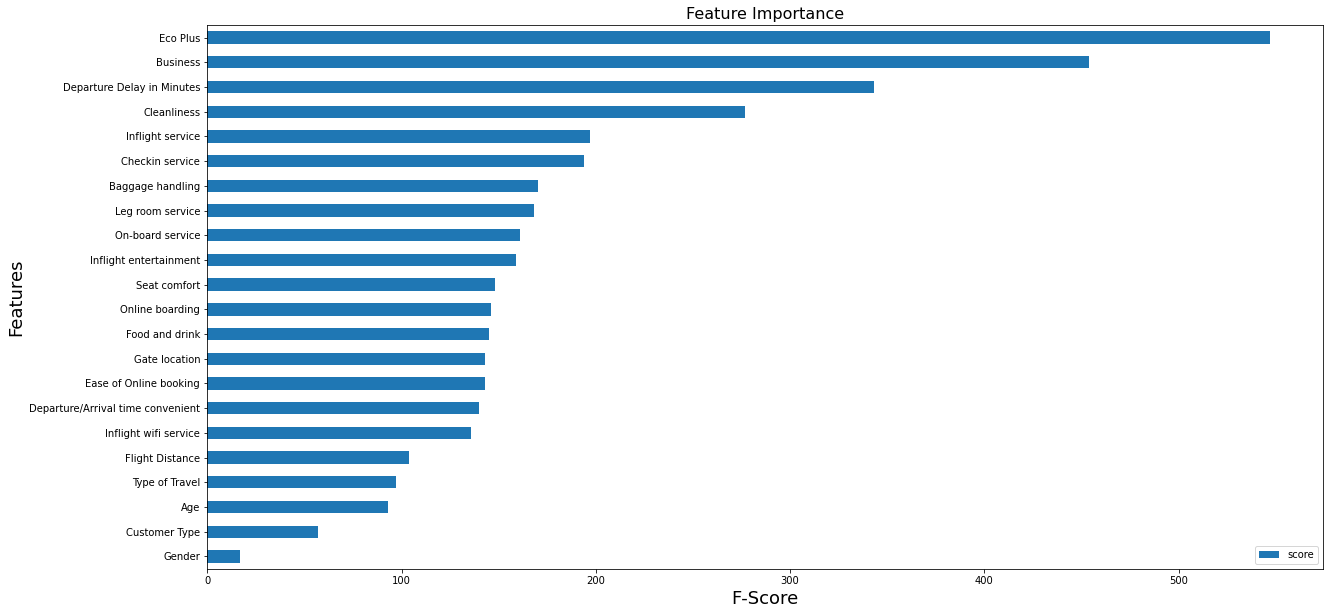

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df1.drop('satisfaction', axis=1)
y = df1['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=91, test_size=0.3)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert X_train back to a DataFrame
X_train = pd.DataFrame(X_train, columns=X.columns)

orig_feature_names = X_train.columns
feature_important = xgb_classifier.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score")
ax = data.plot(kind='barh', figsize=(20, 10))
ax.set_yticklabels(orig_feature_names)
ax.set_xlabel("F-Score", fontsize=18)
ax.set_ylabel("Features", fontsize=18)
ax.set_title('Feature Importance', fontsize=16)